# Laboratorio 7 
Jose Jorge Perez, Diego Ruiz

_________

Se tiene un dataset en el cual se desea analizar la segmentación de clientes de un banco. Es dataset provisto contiene información de diferentes trasacciones realizadas por clientes, de los cuales tenemos información como su fecha de nacimiento, género, ubicación, dinero actual en su cuenta, así como la cantidad de dinero involucrada en la respectiva transacción.


_____________

### Task 1.0: Exploración y Limpieza de Datos

In [1]:
# Importar librerías 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Cargar el dataset
data = pd.read_csv('bank_transactions.csv')

data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


Se encontró que CustomerDOB contaba con datos faltantes, por eso trabajamos para rellenar dichos datos faltantes.

Index([], dtype='object')

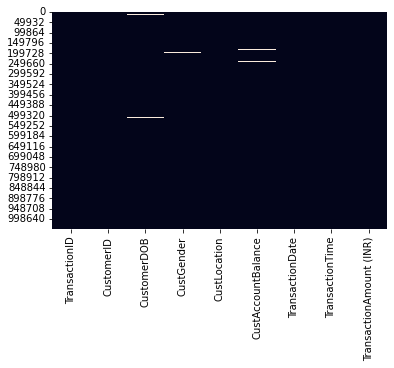

In [2]:
# Matriz de datos faltantes
sns.heatmap(data.isnull(), cbar=False)

data.columns[data.isnull().any()]

for col in data.columns[data.isnull().any()]:

    if data[col].dtype == 'float64' or data[col].dtype == 'int64':
        data[col].fillna(data[col].mean(), inplace=True)

    else:
        data[col].fillna(data[col].mode()[0], inplace=True)

data.columns[data.isnull().any()]

##### Encoding
Convertir variables que no son numéricas a numéricas. En este caso, principalmente se estaba conviertiendo fecha de nacimiento a edad. Se mapeó género a 0 o 1, correspondiente a M y F. Por otro lado, se eliminaron variables de ID, ya que no presentan información útil para la clasificación de clientes; solo son identificadores únicos.

In [3]:
import datetime
from datetime import timedelta, date
from sklearn.preprocessing import LabelEncoder


data['YOB'] = '19' + data['CustomerDOB'].str[-2:]
data['YOB'] = data['YOB'].astype(int)

data = data.drop(['CustomerDOB'], axis=1)
data['Age'] = 2023 - data['YOB']

data = data.drop(['YOB'], axis=1)

# Convertir genero a int. M = 0, F = 1
data['CustGender'] = data['CustGender'].map({'M': 0, 'F': 1})

data = data.drop(['TransactionID'], axis=1)
data = data.drop(['CustomerID'], axis=1)

data = data.drop(['TransactionDate'], axis=1)
data = data.drop(['TransactionTime'], axis=1)

data.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),Age
0,1.0,JAMSHEDPUR,17819.05,25.0,29
1,0.0,JHAJJAR,2270.69,27999.0,66
2,1.0,MUMBAI,17874.44,459.0,27
3,1.0,MUMBAI,866503.21,2060.0,50
4,1.0,NAVI MUMBAI,6714.43,1762.5,35


In [4]:
le = LabelEncoder()
data["CustLocation"] = le.fit_transform(data["CustLocation"])

data.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),Age
0,1.0,3586,17819.05,25.0,29
1,0.0,3648,2270.69,27999.0,66
2,1.0,5268,17874.44,459.0,27
3,1.0,5268,866503.21,2060.0,50
4,1.0,5657,6714.43,1762.5,35



Se determino que es importantes que la siguiente variable esté balanceada:

-CustGender: para verificar que exista una cantidad equilibrada de datos para ambos géneros

In [5]:
data2 = data.copy()

from imblearn.over_sampling import SMOTE

#Calcular cuantas columans son F y cuantas M en CustGender
print('Número de F:',data2[data2['CustGender'] == 1].shape[0])
print('Número de M:',data2[data2['CustGender'] == 0].shape[0])
data2 = data2.dropna(subset=['CustGender'])

# Separar las características y la variable objetivo
X_temp = data2.drop('CustGender', axis=1)
y_temp = data2['CustGender']

#Aplicar SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_temp, y_temp)

data2 = pd.concat([X_resampled, y_resampled], axis=1)

# Contar los valores de cada clase
print('Número de F balanceado:',data2[data2['CustGender'] == 1].shape[0])
print('Número de M balanceado:',data2[data2['CustGender'] == 0].shape[0])

Número de F: 281936
Número de M: 766630
Número de F balanceado: 766630
Número de M balanceado: 766630


In [6]:
print('\n\nMedia y desviación estándar de cada columna:')
data2.describe()



Media y desviación estándar de cada columna:


,CustLocation,CustAccountBalance,TransactionAmount (INR),Age,CustGender
count,1.533260e+06,1.533260e+06,1.533260e+06,1.533260e+06,1533260.0
mean,4.095116e+03,1.137100e+05,1.587819e+03,4.201612e+01,0.5
std,2.358344e+03,8.422872e+05,6.255705e+03,2.006292e+01,0.5
min,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.0
25%,2.075000e+03,5.294190e+03,1.790000e+02,3.200000e+01,0.0
50%,4.008000e+03,1.808739e+04,4.924914e+02,3.600000e+01,0.5
75%,5.792000e+03,6.110604e+04,1.266137e+03,4.200000e+01,1.0
max,9.354000e+03,1.150355e+08,1.560035e+06,1.230000e+02,1.0


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data2)
df_feat = pd.DataFrame(scaled_features, columns=data2.columns)
df_feat.head()

,CustLocation,CustAccountBalance,TransactionAmount (INR),Age,CustGender
0,0.383365,0.000155,0.000016,0.050505,1.0
1,0.389994,0.000020,0.017948,0.424242,0.0
2,0.563182,0.000155,0.000294,0.030303,1.0
3,0.563182,0.007532,0.001320,0.262626,1.0
4,0.604768,0.000058,0.001130,0.111111,1.0


##### Selección de Variables

En este caso, se utilizó la librería de SKLearn para poder escalar y normalizar los datos que lo necesitaran. En el preprocesamiento, se podía observar cómo ciertas variables tenían una alta desviación estándar a comparación de su respectiva media. Esto fue solucionado a través de la función de MinMaxScaler().

Finalmente, se quiso determinar los 2 features que se estarían utilizando para la realización del modelo de agrupación. En este caso, se quería dividir los clientes de un banco en grupos, para así entender la distribución de los mismos. En este caso, sí o sí se quería utilizar como variable CustAccountBalance.

Por otro lado, otra variable de interés era la edad, para así poder entender cómo el dinero del banco está distribuido entre las personas. El top de variables con más correlación a CustAccountBalance son:

1. Age                
2. TransactionAmount (INR)                    

En este caso se utilizará CustAccountBalance, Age y TransactionAmount (INR).


> Sin embargo, para las gráficas únicamente se estará escogiendo CustAccountBalance y Age

In [8]:
corr = df_feat.corr()['CustAccountBalance'].abs().sort_values(ascending=False)
print(corr)

X = df_feat[['Age', 'CustAccountBalance', 'TransactionAmount (INR)']].values

CustAccountBalance         1.000000
Age                        0.094323
TransactionAmount (INR)    0.055203
CustGender                 0.004452
CustLocation               0.002162
Name: CustAccountBalance, dtype: float64


----------
#### K - Means

1. Si considera necesario haga split del dataset como en los laboratorios anteriores. Recuerde que es un problema de aprendizaje no supervisado

En este caso, no se hizo split del dataset ya que no se tiene un problema de aprendizaje supervisado. Simplemente se quiere crear agrupaciones de los clientes del banco.



2. Seleccione el número de clusters que mejor se adapte al dataset. Justifique su elección

Se utilizó la Gráfica de "Elbow" en ambos casos (K-Means manual y de SKLearn) para determinar el punto donde se estabiliza el WSS (o Within-Cluster Sum of Squares). Este punto donde se estabiliza dicho valor es conocido como el "codo" de una gráfica. Se determinó que la mejor cantidad de número de clusters era 3, y se envió este parámetro con los modelos.



3. Investigue sobre Principal Component Analysis (PCA) y responda: ¿Cómo podría ayudarle a mejorar la calidad de sus clusters?

Principal Component Analysis es una técnica que permite analizar datasets muy grandes y reducir su dimensionalidad. Esto se logra transformando la información a un sistema lineal de cordenadas que describe la mayor cantidad posible de la información original. Dicho procedimiento resulta en que se reduzca el ruido así como la complejidad de los datos.

Esto puede ayudar a mejorar la cantidad de nuestros clusters disminuyendo la cantidad de features que se encuentran en el dataset y que producen ruido, sin perder información importante para este.


4. Muestre al menos una gráfica que muestre cómo se dividen los clusters seleccionados. *Seleccione dos features, justifique su elección*

En este caso se crearon 2 gráficas, una para K-Means manual y otra para SKLearn. En ambos casos, se puede observar que se dividen los datos y cómo se crearon los respectivos clusters. Como resultado, se determinó que Age y Transaction Amount eran las variables que más correlación tenían. Por lo cual se utilizaron estas dos en los respectivos modelos además de Customer Account Balance.

Sin embargo, de estas tres variables se gráfico únicamente **Age** y **CustomerAccountBalance** ya que estas son las que proveen información que permite realizar agrupaciones relacionadas al cliente.

En ambas graficas se muestra la relación entre **Customer Account Balance** y **Age**, esto con la intención de poder determinar cómo está distribuído el dinero en el banco y cuáles son los posibles tipos de cliente. Se pudo observar 3 grupos principales: el primero es de los más jóvenes con menos dinero, el segundo es de adultos con más dinero, y por último tenemos a personas mayores con más dinero que los jóvenes pero menos dinero que los adultos. 


5. Provea una métrica de desempeño, justificando su elección

Para seleccionar la cantidad de clusters, se utilizó le métrica de WSS (o Within-Cluster Sum of Squares) y se graficaron los valores de WSS de diferentes modelos con distintos valores de clusters.

Por otro lado, decidió utilizar el índice de Davies–Bouldin para analizar el rendimiento de cada modelo. Este índice indica el promedio de la relación máxima entre la distancia de un punto al centro de su grupo y la distancia entre dos centros de grupos. Un índice bajo indica una buena partición.

--------------

### Task 1.1: Implementacion de K-Means

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
import pandas as pd

def initialize_centroids(X, K):
    # Inicializar los centroides al azar a partir de los puntos de datos
    centroids = X[np.random.choice(X.shape[0], K, replace=False), :]
    return centroids

def assign_clusters(X, centroids):
    # Asignar cada punto de datos al clúster más cercano
    distances = np.sqrt(np.sum((X - centroids[:, np.newaxis])**2, axis=2))
    cluster_assignments = np.argmin(distances, axis=0)
    return cluster_assignments

def update_centroids(X, cluster_assignments, K):
    # Calcular nuevos centroides a partir de los puntos de datos en cada clúster
    centroids = np.zeros((K, X.shape[1]))
    for i in range(K):
        centroids[i,:] = np.mean(X[cluster_assignments == i, :], axis=0)
    return centroids

def kmeans(X, K, max_iters=100):
    centroids = initialize_centroids(X, K)
    for i in range(max_iters):
        cluster_assignments = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, cluster_assignments, K)
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return centroids, cluster_assignments

Al hacer la gráfica "elbow" (codo) se puede determinar que con 3 clusters empieza a normalizarse el WSS y ya no decrece a una velocidad tan rápida. Por tal razón, el modelo final utilizará 3 clusters. 

k: 1 cost: 63052.18144111315
k: 2 cost: 11272.270176335167
k: 3 cost: 4430.590313621413
k: 4 cost: 2435.633222733624
k: 5 cost: 1585.8505465266705
k: 6 cost: 1198.3705133477893
k: 7 cost: 980.170718915145
k: 8 cost: 815.6697519871792


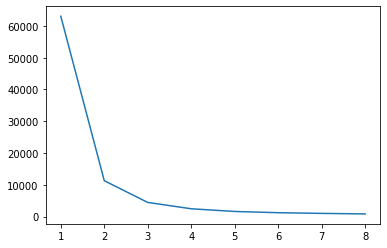

In [11]:
def calculate_WSS(points, kmax=10):
  sse = []
  for k in range(1, kmax+1):
    centroids, cluster_assignments = kmeans(points, k)
    curr_sse = 0
    
    # equivalente a inertia en sklearn
    for i in range(len(points)):
      curr_center = centroids[cluster_assignments[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    print("k:",k, "cost:", curr_sse)
    sse.append(curr_sse)

  return sse

sse = calculate_WSS(X, kmax=8)

fig = plt.figure()
ax = plt.axes()

x_plot = list(range(1,9))
ax.plot(x_plot, sse)

En base al valor de K determinado anteriormente, se creó una gráfica para poder demostrar las agrupaciones realizadas por el modelo.

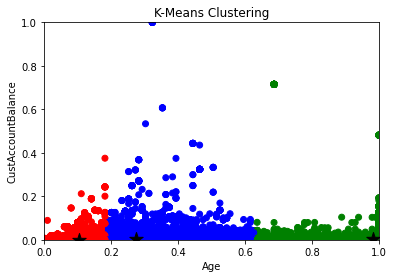

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Calcular los centroides y los índices de asignación de clúster
# X Contiene las variables con mayor correlación a CustAccountBalance. i.e. Age, CustAccountBalance, TransactionAmount (INR)...
centroids, cluster_assignments = kmeans(X, K=3) 

fig = plt.figure()
ax = fig.add_subplot(111)

# Assign different colors to each cluster
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'b']
cluster_colors = [colors[i] for i in cluster_assignments]

# Plot the data points
ax.scatter(df_feat['Age'], df_feat['CustAccountBalance'], c=cluster_colors)

# Plot the centroids
ax.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='*', s=200)

# Set the axis labels
ax.set_xlabel('Age')
ax.set_ylabel('CustAccountBalance')
ax.set_title('K-Means Clustering')

ax.set_xlim([min(df_feat['Age']), max(df_feat['Age'])])
ax.set_ylim([min(df_feat['CustAccountBalance']), max(df_feat['CustAccountBalance'])])

plt.show()

In [13]:
# Davies-Bouldin Index
from sklearn.metrics import davies_bouldin_score
print(davies_bouldin_score(X, cluster_assignments))

0.43560255916931895


----------
### Task 1.2: K-Means (CON PCA)

k: 1 cost: 63052.52072629977
k: 2 cost: 11272.496529612887
k: 3 cost: 4430.702840133551
k: 4 cost: 2381.214565219319
k: 5 cost: 1538.7679670506568
k: 6 cost: 1122.43013443255
k: 7 cost: 853.3725621880657
k: 8 cost: 689.2418145394064


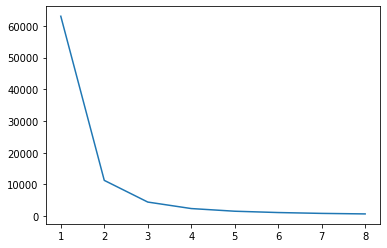

In [14]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# Determinar la mejor cnatidad de clusters a través de Within-Cluster Sum of Squares (WSS) 
def calculate_WSS(points, kmax=10):
  sse = []

  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k, n_init='auto').fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
    print("k:",k, "cost:", curr_sse)

  return sse


# PCA implementation
pca = PCA(n_components=2)
pca.fit(X)
pca_data = pca.transform(X)

# Grafica de codo
sse = calculate_WSS(pca_data, kmax=8)

fig = plt.figure()
ax = plt.axes()

x_plot = list(range(1,9))
ax.plot(x_plot, sse)

C:\Users\JJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


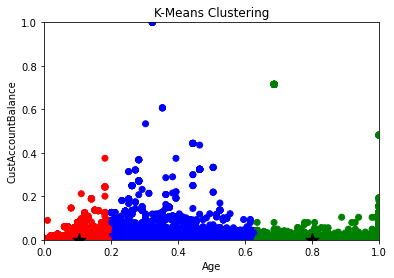

In [15]:
# Calcular los centroides y los índices de asignación de clúster
kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_data)
centroids = kmeans.cluster_centers_
cluster_assignments = kmeans.labels_

fig = plt.figure()
ax = fig.add_subplot(111)

# Assign different colors to each cluster
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'b']
cluster_colors = [colors[i] for i in cluster_assignments]

# Plot the data points
ax.scatter(df_feat['Age'], df_feat['CustAccountBalance'], c=cluster_colors)

# Plot the centroids
ax.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='*', s=200)

# Set the axis labels
ax.set_xlabel('Age')
ax.set_ylabel('CustAccountBalance')
ax.set_title('K-Means Clustering')

ax.set_xlim([min(df_feat['Age']), max(df_feat['Age'])])
ax.set_ylim([min(df_feat['CustAccountBalance']), max(df_feat['CustAccountBalance'])])

plt.show()

In [16]:
# Davies-Bouldin Index
print(davies_bouldin_score(X, cluster_assignments))

0.42678428539400654
